In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('amazon-fine-food-reviews/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.shape

(568454, 10)

In [4]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
df['ProductId'].nunique()

74258

In [7]:
df['Score'].value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

Sentiment
2    443777
0     82037
1     42640
Name: count, dtype: int64


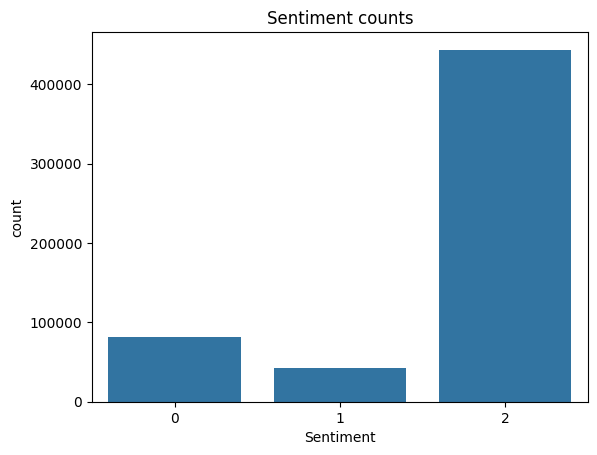

In [8]:
# Create sentiment label: 1-2 -> Negative, 3 -> Neutral, 4-5 -> Positive
def sentiment_label(score):
    if score <= 2:
        return 0
    elif score == 3:
        return 1
    else:
        return 2

df['Sentiment'] = df['Score'].apply(sentiment_label)
print(df['Sentiment'].value_counts())
sns.countplot(x='Sentiment', data=df)
plt.title("Sentiment counts")
plt.show()

# Seperating some data for Sample Predictions

In [9]:
product_counts = df['ProductId'].value_counts()

eligible_products = product_counts[product_counts >= 100].index

len(eligible_products)

866

In [10]:
np.random.seed(42)

selected_products = np.random.choice(eligible_products, size=10, replace=False)

In [11]:
selected_products

array(['B001EO5U8I', 'B006N3I0N2', 'B000SATIZA', 'B001EO5R0Y',
       'B005K4Q34S', 'B008GRONV6', 'B005GIF5UQ', 'B00248EE4O',
       'B0009YUEG2', 'B001EQ4QJK'], dtype=object)

In [12]:
## Extracting 50 reviews

dashboard_data = pd.DataFrame()

for pid in selected_products:
    temp = df[df['ProductId'] == pid].sample(50, random_state=42)
    dashboard_data = pd.concat([dashboard_data, temp])

In [13]:
dashboard_data['ProductId'].value_counts()

ProductId
B001EO5U8I    50
B006N3I0N2    50
B000SATIZA    50
B001EO5R0Y    50
B005K4Q34S    50
B008GRONV6    50
B005GIF5UQ    50
B00248EE4O    50
B0009YUEG2    50
B001EQ4QJK    50
Name: count, dtype: int64

In [14]:
df = df.drop(dashboard_data.index)

In [15]:
df['Text'] = df['Text'].astype(str).str.lower()


In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input,Embedding,LSTM,Dense,Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2026-02-18 06:48:36.837747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771397317.012444      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771397317.065860      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771397317.494551      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771397317.494575      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771397317.494577      55 computation_placer.cc:177] computation placer alr

In [17]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['Text'],
    df['Sentiment'],
    test_size=0.15,
    stratify=df['Score'],
    random_state=42
)

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text,
    y_train,
    test_size=0.15,
    stratify=y_train,
    random_state=42
)

In [18]:
MAX_WORDS = 40000
MAX_LEN = 200

In [19]:
tokenizer = Tokenizer(num_words=MAX_WORDS,oov_token="<OOV>")

tokenizer.fit_on_texts(X_train_text)

X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(X_test_text)

X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='post',truncating='post')
X_val = pad_sequences(X_val, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='post',truncating='post')

In [20]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [21]:
model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=MAX_WORDS,output_dim=64),
    #LSTM(128,return_sequences=True,dropout=0.3,recurrent_dropout=0.3),
    LSTM(64,dropout=0.3,recurrent_dropout=0.3),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

I0000 00:00:1771397368.791830      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [22]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,597,379 (9.91 MB)

 Trainable params: 2,597,379 (9.91 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 840s 521ms/step - accuracy: 0.7780 - loss: 0.6897 - val_accuracy: 0.7822 - val_loss: 0.6601
Epoch 2/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 831s 519ms/step - accuracy: 0.7851 - loss: 0.6518 - val_accuracy: 0.8489 - val_loss: 0.4192
Epoch 3/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 832s 519ms/step - accuracy: 0.8568 - loss: 0.3970 - val_accuracy: 0.8754 - val_loss: 0.3308
Epoch 4/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 835s 521ms/step - accuracy: 0.8850 - loss: 0.3097 - val_accuracy: 0.8908 - val_loss: 0.2994
Epoch 5/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 833s 520ms/step - accuracy: 0.9013 - loss: 0.2660 - val_accuracy: 0.8978 - val_loss: 0.2849
Epoch 6/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 824s 514ms/step - accuracy: 0.9164 - loss: 0.2294 - val_accuracy: 0.9014 - val_loss: 0.2785
Epoch 7/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 822s 513ms/step - accuracy: 0.9263 - loss: 0.2055 - val_accuracy: 0.9052 - val_loss: 0.2808
Epoch 8/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 825s 514ms/step - ac

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_pred_probs = model.predict(X_test)


2663/2663 ━━━━━━━━━━━━━━━━━━━━ 241s 91ms/step


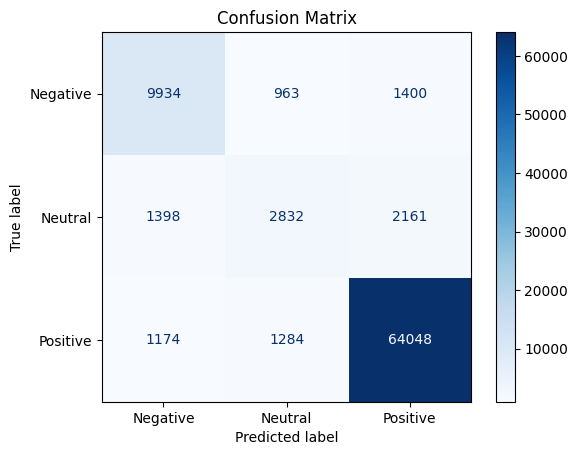

              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80     12297
     Neutral       0.56      0.44      0.49      6391
    Positive       0.95      0.96      0.96     66506

    accuracy                           0.90     85194
   macro avg       0.77      0.74      0.75     85194
weighted avg       0.90      0.90      0.90     85194



In [34]:
# Convert to class indices (0–2)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Negative','Neutral','Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred,
                            target_names=['Negative','Neutral','Positive']))

## ROC–AUC Curves

Macro ROC-AUC: 0.9480429957102774
Micro ROC-AUC: 0.9796972743949944


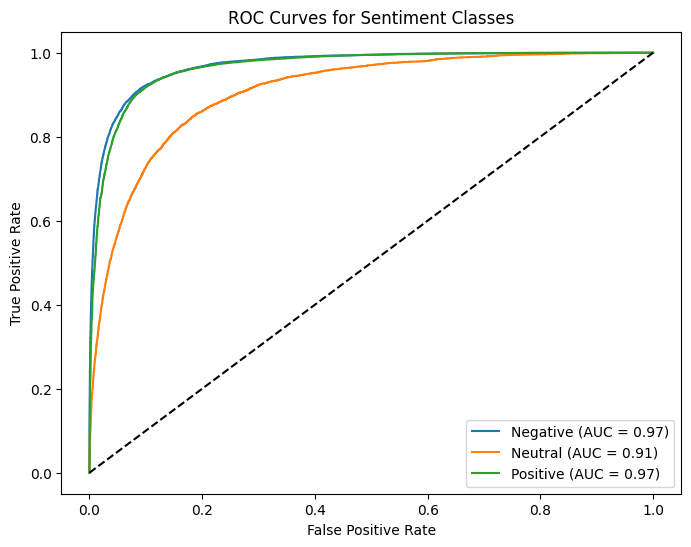

In [35]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Binarize labels for one-vs-rest ROC
y_test_bin = label_binarize(y_test, classes=[0,1,2])

# Macro & Micro ROC-AUC
macro_auc = roc_auc_score(y_test_bin, y_pred_probs, average='macro', multi_class='ovr')
micro_auc = roc_auc_score(y_test_bin, y_pred_probs, average='micro', multi_class='ovr')

print("Macro ROC-AUC:", macro_auc)
print("Micro ROC-AUC:", micro_auc)

# Plot ROC curves per class
plt.figure(figsize=(8,6))
for i, label in enumerate(['Negative','Neutral','Positive']):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Sentiment Classes")
plt.legend(loc="lower right")
plt.show()


In [36]:
dashboard_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
523012,523013,B001EO5U8I,A3Q2XQ803BLXME,"C. Drennon ""the stitch""",2,2,5,1255219200,Great green tea for not too much.,Stash's gunpowder green has been a staple tea ...,2
523049,523050,B001EO5U8I,A3UR5KVANJF2W3,"Yooper Gal ""bird watcher""",0,0,4,1326412800,E.G. tea,Nice light earl grey flavor. pleasant aroma. U...,2
523044,523045,B001EO5U8I,A2U4YO4IY98IB7,"M. Thomas ""M. Thomas""",0,0,5,1333065600,Good stuff,Back to buy more. Love this tea! I have had ...,2
523029,523030,B001EO5U8I,A2FRFAQCWZJT3Q,"B. Davis ""The Happy Hermit""",1,1,5,1216771200,Good stuff!!,Two level measuring teaspoons makes at least 3...,2
523024,523025,B001EO5U8I,A1LVEPRENTHRSH,Amazon Customer B,1,1,5,1266969600,Sweet Jasmine,I am a long-time green tea consumer. I switch...,2


In [38]:
# Random review text from dashboard_data
sample_text = dashboard_data['Text'].sample(1).iloc[0]
print("Sample Review:", sample_text)
sample_text = sample_text.lower()
print("\n")

# Tokenize and pad
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_seq = pad_sequences(sample_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Predict
pred_probs = model.predict(sample_seq)
pred_class = np.argmax(pred_probs, axis=1)[0]   # 0,1,2

# Map numeric class to sentiment label
class_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
pred_label = class_labels[pred_class]

print(f"Predicted Class: {pred_class} ({pred_label})")
print("Probability Distribution:", pred_probs[0])



Sample Review: I just wanted to say I was very pleasantly surprised to receive this tea in such a huge bag!  The tea is so yummy.  I just pour boiling water over a few petals from the kettle and let steep 5 mins.  Sometimes I add a spoon of sugar but most of the time just drink it without.  When the tea is ready to drink, all the petals sink to the bottom and I don't bother removing them till after I've drank the tea.  I am hooked!  Love it!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Predicted Class: 2 (Positive)
Probability Distribution: [6.4069005e-05 4.8876560e-04 9.9944717e-01]


In [39]:
# Example new reviews
new_texts = [
    "The food was absolutely wonderful, fresh and flavorful.",
    "Terrible service, I will never come back.",
    "It was okay, nothing special but not bad either."
]

# Convert to sequences
new_seq = tokenizer.texts_to_sequences(new_texts)

# Pad to same length as training
new_seq = pad_sequences(new_seq, maxlen=MAX_LEN)

# Predict
pred_probs = model.predict(new_seq)

pred_classes = np.argmax(pred_probs, axis=1)

for text, score in zip(new_texts, pred_classes):
    print(f"Review: {text}\nPredicted Score: {score}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Review: The food was absolutely wonderful, fresh and flavorful.
Predicted Score: 2

Review: Terrible service, I will never come back.
Predicted Score: 0

Review: It was okay, nothing special but not bad either.
Predicted Score: 1



In [41]:
# Save the model to HDF5 format
model.save("amazon_fine_food_model.h5")